## Import modules and define functions

In [1]:
# This file is part of CbM (https://github.com/ec-jrc/cbm).
# Author    : WIRNHARDT Csaba
# Credits   : GTCAP Team
# Copyright : 2021 European Commission, Joint Research Centre
# License   : 3-Clause BSD


import requests
import json
import pandas as pd
import datetime
import os
import matplotlib.dates as mdates
import sys
import calendar
from matplotlib import pyplot

def get_s1_coh_data_from_restful(ms, year, fid):
    # Set you RESTful API Credentials
    api_user = ''
    api_pass = ''
    api_host = 'http://185.178.85.7/'

    url = api_host + "query/parcelTimeSeries?aoi=" + ms + "&year=" + str(year) + "&pid=" + str(fid) + "&tstype=c6"  
    print(url)
    response = requests.get(url, auth=(api_user, api_pass))
    coh_profile = pd.read_json(response.text)

    if not coh_profile.empty:
        coh_profile['date_part']=coh_profile['date_part'].map(lambda e: datetime.datetime.fromtimestamp(e))
        coh_profile['orbit'] = coh_profile['date_part'].apply(lambda s: 'D' if s.hour < 12 else 'A')
        coh_profile['date'] = coh_profile['date_part'].apply(lambda s: s.date())
        return coh_profile
    else:
        return

def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month    
    
def plot_radar_data_orbits_together(output_graph_folder, radar_profile_filtered,
                                   plot_title, fixed_date_range, x_start_date, x_end_date,
                                   parcel_id, fid, separate_orbits):

    if not os.path.exists(output_graph_folder):
        os.makedirs(output_graph_folder)

    # plot the time series
    ax0 = pyplot.gca()

    if not separate_orbits:
        radar_profile_filtered.plot(kind='line', marker='+', x='date',y='meanVV', color = 'lightblue', ax=ax0)  
        radar_profile_filtered.plot(kind='line', marker='+', x='date',y='meanVH', color = 'orange', ax=ax0)  
    else:
#         radar_profile_filtered[radar_profile_filtered['orbit']=='A'].plot(kind='line', marker='+', x='date',y='meanVV', label='VV Asc', color = 'lightblue', ax=ax0)  
#         radar_profile_filtered[radar_profile_filtered['orbit']=='A'].plot(kind='line', marker='+', x='date',y='meanVH', label='VH Asc', color = 'darkorange', ax=ax0)  

#         radar_profile_filtered[radar_profile_filtered['orbit']=='D'].plot(kind='line', marker='+', x='date',y='meanVV', label='VV Desc', color = 'cadetblue', ax=ax0)  
#         radar_profile_filtered[radar_profile_filtered['orbit']=='D'].plot(kind='line', marker='+', x='date',y='meanVH', label='VH Desc', color = 'gold', ax=ax0)  

        radar_profile_filtered[(radar_profile_filtered["orbit"]=="D") & (radar_profile_filtered["band"]=="VVc")].plot(kind='line', marker='+', x='date',y='mean', label='VV Desc', ax=ax0)  
        radar_profile_filtered[(radar_profile_filtered["orbit"]=="A") & (radar_profile_filtered["band"]=="VVc")].plot(kind='line', marker='+', x='date',y='mean', label='VV Asc', ax=ax0)  

        radar_profile_filtered[(radar_profile_filtered["orbit"]=="D") & (radar_profile_filtered["band"]=="VHc")].plot(kind='line', marker='+', x='date',y='mean', label='VH Desc', ax=ax0)  
        radar_profile_filtered[(radar_profile_filtered["orbit"]=="A") & (radar_profile_filtered["band"]=="VHc")].plot(kind='line', marker='+', x='date',y='mean', label='VH Asc', ax=ax0)  
        
        
#         radar_profile_filtered[radar_profile_filtered['orbit']=='D'].plot(kind='line', marker='+', x='date',y='meanVV', label='VV Desc', ax=ax0)  
#         radar_profile_filtered[radar_profile_filtered['orbit']=='A'].plot(kind='line', marker='+', x='date',y='meanVV', label='VV Asc', ax=ax0)  
#         radar_profile_filtered[radar_profile_filtered['orbit']=='D'].plot(kind='line', marker='+', x='date',y='meanVH', label='VH Desc', ax=ax0)  
#         radar_profile_filtered[radar_profile_filtered['orbit']=='A'].plot(kind='line', marker='+', x='date',y='meanVH', label='VH Asc', ax=ax0)  

    # format the graph a little bit
    # we check the first meanVV value and if it is positive we assume it is coherence

    pyplot.ylabel(r'Coherence')

    pyplot.title(plot_title + ", Parcel id: " + str(parcel_id) + " fid: " + str(fid)+ " " + crop)
    # ax0.set_ylim([-0.3,1])
    ax0.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax0.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    ax0.xaxis.grid() # horizontal lines
    ax0.yaxis.grid() # vertical lines

    fig = pyplot.gcf()
    fig.autofmt_xdate() # Rotation
    fig_size_x = 13
    fig_size_y = 7
    fig.set_size_inches(fig_size_x, fig_size_y)


    if fixed_date_range:
        x_start_date_date = datetime.datetime.strptime(x_start_date, '%Y-%m-%d').date()
        x_end_date_date = datetime.datetime.strptime(x_end_date, '%Y-%m-%d').date()
        min_month = x_start_date_date.month
        min_year = x_start_date_date.year
        max_month = x_end_date_date.month
        max_year = x_end_date_date.year
        number_of_months = diff_month(x_end_date_date, x_start_date_date) + 1
    else:
        min_month = min(radar_profile_filtered['date']).date().month
        min_year = min(radar_profile_filtered['date']).date().year
        max_month = max(radar_profile_filtered['date']).date().month
        max_year = max(radar_profile_filtered['date']).date().year
        number_of_months = diff_month(max(radar_profile_filtered['date']).date(), min(radar_profile_filtered['date']).date()) + 1

    ax0.set_xlim([datetime.date(min_year, min_month, 1), 
                  datetime.date(max_year, max_month,
                                calendar.monthrange(max_year, max_month)[1])])

    min_year_month = str(min_year) + ('0' + str(min_month))[-2:]
    step_x = 1/number_of_months
    start_x = step_x/2               # positions are in graph coordinate system between 0 and 1
                                     # so first year_month label is at half the size of the widht of
                                     # one month
    loc_y = 0.915
    current_year_month_text = get_current_list_of_months(min_year_month, number_of_months)
    for current_year_month_index in range (0, number_of_months):
        t = current_year_month_text[current_year_month_index]
        loc_x = start_x + (current_year_month_index) * step_x
        ax0.text(loc_x, loc_y, t, verticalalignment='bottom', horizontalalignment='center', transform=ax0.transAxes,
                color='blue', fontsize=13)
    ax0.legend()
    ax0.set_ylim([0,1])
    
#     handles, labels = ax0.get_legend_handles_labels()
#     order = [0,2,1,3]
#     pyplot.legend([handles[idx] for idx in order],[labels[idx] for idx in order])    

    # save the figure to a jpg file
    if save_figures:
        fig.savefig(output_graph_folder + '/' + jpg_filename) 
        pyplot.close(fig)    

def get_current_list_of_months(first_year_month, number_of_year_months):
    textstrs_tuples = [
                       ("201701", "2017\nJAN"),
                       ("201702", "2017\nFEB"),
                       ("201703", "2017\nMAR"),
                       ("201704", "2017\nAPR"),
                       ("201705", "2017\nMAY"),
                       ("201706", "2017\nJUN"),
                       ("201707", "2017\nJUL"),
                       ("201708", "2017\nAUG"),
                       ("201709", "2017\nSEP"),
                       ("201710", "2017\nOCT"),
                       ("201711", "2017\nNOV"),
                       ("201712", "2017\nDEC"),
                       ("201801", "2018\nJAN"),
                       ("201802", "2018\nFEB"),
                       ("201803", "2018\nMAR"),
                       ("201804", "2018\nAPR"),
                       ("201805", "2018\nMAY"),
                       ("201806", "2018\nJUN"),
                       ("201807", "2018\nJUL"),
                       ("201808", "2018\nAUG"),
                       ("201809", "2018\nSEP"),
                       ("201810", "2018\nOCT"),
                       ("201811", "2018\nNOV"),
                       ("201812", "2018\nDEC"),
                       ("201901", "2019\nJAN"),
                       ("201902", "2019\nFEB"),
                       ("201903", "2019\nMAR"),
                       ("201904", "2019\nAPR"),
                       ("201905", "2019\nMAY"),
                       ("201906", "2019\nJUN"),
                       ("201907", "2019\nJUL"),
                       ("201908", "2019\nAUG"),
                       ("201909", "2019\nSEP"),
                       ("201910", "2019\nOCT"),
                       ("201911", "2019\nNOV"),
                       ("201912", "2019\nDEC"),
                       ("202001", "2020\nJAN"),
                       ("202002", "2020\nFEB"),
                       ("202003", "2020\nMAR"),
                       ("202004", "2020\nAPR"),
                       ("202005", "2020\nMAY"),
                       ("202006", "2020\nJUN"),
                       ("202007", "2020\nJUL"),
                       ("202008", "2020\nAUG"),
                       ("202009", "2020\nSEP"),
                       ("202010", "2020\nOCT"),
                       ("202011", "2020\nNOV"),
                       ("202012", "2020\nDEC"),
                       ("202101", "2021\nJAN"),
                       ("202102", "2021\nFEB"),
                       ("202103", "2021\nMAR"),
                       ("202104", "2021\nAPR"),
                       ("202105", "2021\nMAY"),
                       ("202106", "2021\nJUN"),
                       ("202107", "2021\nJUL"),
                       ("202108", "2021\nAUG"),
                       ("202109", "2021\nSEP"),
                       ("202110", "2021\nOCT"),
                       ("202111", "2021\nNOV"),
                       ("202112", "2021\nDEC"),                       
                      ]

    # find the index of the first occurrence of first_year_month in textstrs_tuples
    # and return the rest secend elements of the tuples of the list

    i = 0
    first_year_month_index = i
    for textstrs_tuple in textstrs_tuples:
        if first_year_month == textstrs_tuple[0]:
            first_year_month_index = i
        i+=1

    current_textstrs = []
    for i in range(first_year_month_index, first_year_month_index + number_of_year_months):
        current_textstrs.append(textstrs_tuples[i][1])

    return current_textstrs


### Extract profile from database with RESTful service and plot graphs

http://185.178.85.7/query/parcelTimeSeries?aoi=bewa&year=2020&pid=58950&tstype=c6
58950 58950 


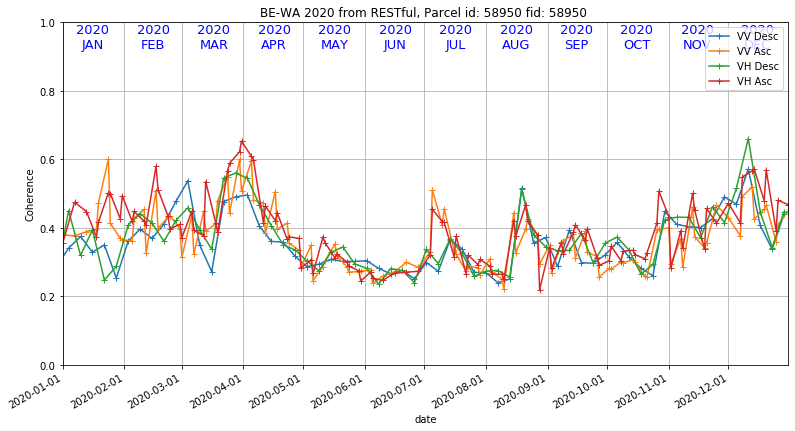

In [3]:
# fid = 183
# ms = "at"
# year = 2020

fid = 123
ms = ""
year = 2020

output_graph_folder = "temp" + ms.upper() + "/mowing_detection/coh_graphs"
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
radar_profile_filtered = get_s1_coh_data_from_restful(ms, year, fid)
# sort by date
radar_profile_filtered = radar_profile_filtered.sort_values(by=['date'])
crop = ""
parcel_id = str(fid)

print(fid,parcel_id,crop)
# Then plot the graph and save it to a file

plot_title = ms.upper() + " " + str(year) + " from RESTful"

fixed_date_range = True
save_figures = False
jpg_filename = str(fid) + ".jpg"

x_start_date = "2020-01-01"
x_end_date = "2020-12-31"

separate_orbits = True

plot_radar_data_orbits_together(output_graph_folder, radar_profile_filtered,
                                   plot_title, fixed_date_range, x_start_date, x_end_date,
                                   parcel_id, fid, separate_orbits)

